In [1]:
%matplotlib inline
from dbm import DBM
import tensorflow as tf
import utils
import numpy as np
from train_rbm import load_model
import cPickle
import matplotlib.pyplot as plt


In [2]:
def load_dataset():
    (train_xs, _), _, _ = cPickle.load(file('mnist.pkl', 'rb'))
    init = cPickle.load(file('testdigits.pkl','rb'))
    #plt.imshow(init[1].reshape(28,28), cmap='gray')

    return train_xs.reshape((-1, 28, 28, 1)), init

def build_dcbm(layers, name):
    conv = 1
    fc = 1
    input_shape = [28, 28, 1] if layers[0][0]=='conv' else [28*28]
    dbm = DBM(input_shape, name=name)
    for layer in layers:
        if layer[0] == 'conv':
            filter_shape = layer[1]
            stride = layer[2]
            dbm.add_conv_layer(filter_shape, stride, 'VALID', 'conv%d'%conv)
            conv += 1
        elif layer[0] == 'fc':
            dbm.add_fc_layer(layer[1], 'fc%d'%fc)
            fc += 1
    dbm.print_network()
    return dbm

In [3]:
def load_testset():
    _, _, (test_xs, test_ys) = cPickle.load(file('mnist.pkl', 'rb'))
    return test_xs.reshape((-1, 28, 28)), test_ys

test_xs, test_ys = load_testset()
samples = [] #5 38 32 19 23 21 0 -80 12
for i in [10, 5, 38, 32,19, 23, 21, 0, -80, 12]:
    samples.append(test_xs[i])
samples = np.array(samples)
cPickle.dump(samples, open('testdigits.pkl','wb'))

In [4]:
# rebuild the same model as the one to load, with the same name for the model as well as layers

config = (['conv',(12,12,1,64), (2,2)], 
         ['conv',(5,5,64,128),(2,2)],
         ['fc', 500]
        )
name = 'dbm_0'
model = build_dcbm(config, name)
# name = 'dbm_mini'
# model = DBM([28, 28, 1], name=name)
# model.add_conv_layer((12,12,1,32), (2,2), 'VALID', 'conv1')
# model.add_conv_layer((5,5,32,64), (2,2), 'VALID', 'conv2')
# model.add_fc_layer(500,'fc1')
# model.print_network()


-----Network Dimensions-----
[28, 28, 1]
[9, 9, 64]
[1152]
[500]
----------------------------


Model loaded from: evo_dbm_0/dbm_0-epoch49.ckpt
[<crbm.CRBM object at 0x7ff646b8af50>, <crbm.CRBM object at 0x7ff646b8ae90>, <rbm.RBM object at 0x7ff646b8aed0>]
(12, 12, 1, 64)
(5, 5, 64, 128)
(1152, 500)


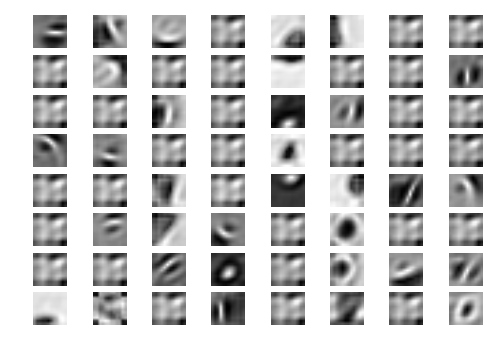

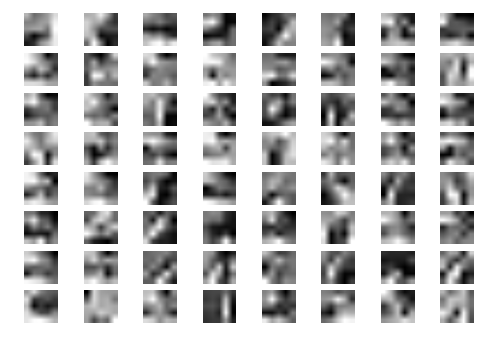

In [8]:
epoch = 49
model_name = 'dbm_0'
MODEL_PATH = 'evo_%s/%s-epoch%d.ckpt' % (model_name, model_name, epoch)

# start a session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

with sess.as_default():

    load_model(sess, MODEL_PATH)
    print model.rbm_list
    
    # collect weights
    model_parameters = model.rbm_list[0].get_model_parameters()
    w0 = model_parameters['weights']
    print w0.shape # (12, 12, 1, 64)
    w0 = w0[:,:,0,:].reshape(12*12, -1)
    
    model_parameters = model.rbm_list[1].get_model_parameters()
    w1 = model_parameters['weights']
    print w1.shape # (5, 5, 64, 128)
    w1 = w1[:,:,:,0].reshape(25, -1)
    
    model_parameters = model.rbm_list[2].get_model_parameters()
    #print model_parameters
    w2 = model_parameters['weights']
    print w2.shape # (5, 5, 64, 128)
    
    # visualize
    utils.vis_images(w0, 8, 8, (12,12), 'filters/%s_epoch%d_w0.png' % (model_name, epoch))
    # utils.vis_images(w1, 8, 8, (5,5), 'filters/%s_epoch%d_w1.png' % (model_name, epoch))
    
    # obvious noise
    # utils.vis_images(w2[:,:100], 10, 10, (24,24), 'filters/%s_epoch%d_w2.png' % (model_name, epoch))


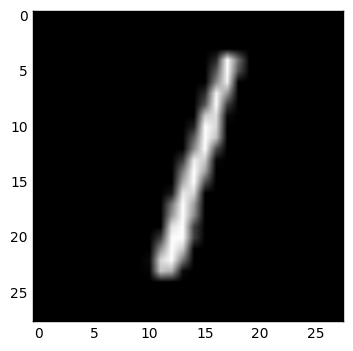